# Assignment 6 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.0 installed. This means, you should be able to use it without any changes to your environment.

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.6G):
```
mkdir -p ~/.torch/models
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/models/models/* ~/.torch/models
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

**Here is an example of the training data:**

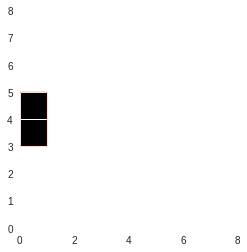

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# setting torch parameters as suggested in docs to reduce fluctuation in model results.
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
# print(bboxes)
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0
# print(imgs)

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
# print(imgs.shape, bboxes.shape)

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [2]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
print(X.shape, np.mean(X), np.std(X))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
print(y.shape, np.mean(y), np.std(y))

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

# print(X.shape[-1])
# print(y.shape[-1])

cuda_capable = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_capable else "cpu")
print("Device has CUDA support: ", cuda_capable)
if cuda_capable == True:
  torch.cuda.manual_seed_all(0)

(50000, 64) -1.4566126083082053e-18 1.0
(50000, 4) 0.281788125 0.1753297770887318
Device has CUDA support:  True


## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Find_Rect_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(X.shape[1], 200)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(200,y.shape[1])

    def forward(self, x):
        x = F.relu(self.hidden(x))
        return self.out(x)

model = Find_Rect_Logistic()
model = model.to(device)
print(model)

Find_Rect_Logistic(
  (hidden): Linear(in_features=64, out_features=200, bias=True)
  (dropout): Dropout(p=0.2)
  (out): Linear(in_features=200, out_features=4, bias=True)
)


In [4]:
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.03, rho=0.95, eps=1e-06, weight_decay=0.07)
loss_fn = torch.nn.MSELoss(size_average=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [6]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
print('Training the model.')
for epoch in range(5000):
    if (epoch+1)%200 == 0:
      print('Epoch ', epoch+1, '/ 5000')
    optimizer.zero_grad()
   
    #print(inputs.shape)
    model.train().to(device)
    outputs = model(inputs.to(device))

    #print(outputs.shape)
    #print(labels.shape)
    loss = loss_fn(outputs.to(device), labels.to(device))
    loss = loss.to(device)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

print('Model Trained.')

Training the model.
Epoch  200 / 5000
Epoch  400 / 5000
Epoch  600 / 5000
Epoch  800 / 5000
Epoch  1000 / 5000
Epoch  1200 / 5000
Epoch  1400 / 5000
Epoch  1600 / 5000
Epoch  1800 / 5000
Epoch  2000 / 5000
Epoch  2200 / 5000
Epoch  2400 / 5000
Epoch  2600 / 5000
Epoch  2800 / 5000
Epoch  3000 / 5000
Epoch  3200 / 5000
Epoch  3400 / 5000
Epoch  3600 / 5000
Epoch  3800 / 5000
Epoch  4000 / 5000
Epoch  4200 / 5000
Epoch  4400 / 5000
Epoch  4600 / 5000
Epoch  4800 / 5000
Epoch  5000 / 5000
Model Trained.


Plotting Loss.


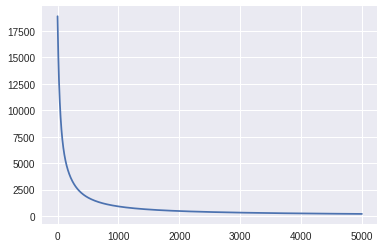

In [7]:
print('Plotting Loss.')
plt.plot(loss_record)

In [8]:
# Predict bounding boxes on the test images.
input_bbox = Variable(torch.Tensor(test_X))
model.eval().to(device)
pred_y = model(input_bbox.to(device))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [0]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.8865467565963696

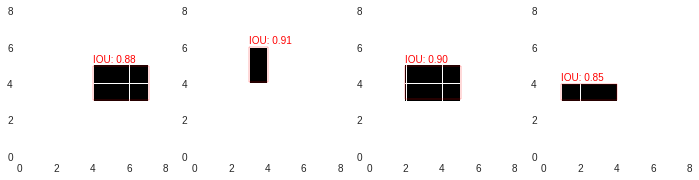

In [10]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.Copy the relevant code into this notebook, as mentioned in the submission instructions.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.

### Hints for step 3

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG19 instead.

Next, print out the new model_conv and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but works similarily. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

To change the structure of Sequential component called ```module_name``` and to modify its last layer into a DifferentLayer type, you can use this syntax.

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old model_conv.module_name with the differently structured version.

##**Step 1: Load Data**


We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. We are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

.. Note :: Download the data from here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>_ and extract it to the current directory.

In [11]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests, zipfile, io

plt.ion()   # interactive mode


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
r = requests.get(url, allow_redirects=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./hymenoptera_dataset")

data_dir = "./hymenoptera_dataset/hymenoptera_data/"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('dataset loaded successfully.')

cuda:0
dataset loaded successfully.


##**Step 1.1: Visualize function**

To visualize the dataset and model predcitions.

Peek into the dataset.


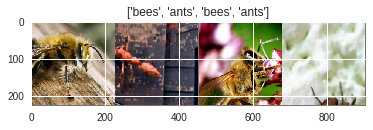

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

print('Peek into the dataset.')
imshow(out, title=[class_names[x] for x in classes])


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Step 2: Training the model

General function to train a model. Here, we will illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

Later, resnet pretrained model is used to classify ants and bees.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# RESNET pretarined model used to classify ants and bees using transfer learning approach
model = models.resnet18(pretrained=True)
print('Original: \n', model, '\n')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

print('Modified to have two class output: \n', model)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Original: 
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
     

In [15]:
# Train phase
print('Training Phase: pre-traind resnet model is being trained.\n')
model_resnet = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Training Phase: pre-traind resnet model is being trained.

Epoch 0/29
----------
train Loss: 0.5806 Acc: 0.7090
val Loss: 0.1861 Acc: 0.9412

Epoch 1/29
----------
train Loss: 0.4574 Acc: 0.7828
val Loss: 0.3194 Acc: 0.8693

Epoch 2/29
----------
train Loss: 0.3978 Acc: 0.8402
val Loss: 0.1992 Acc: 0.9346

Epoch 3/29
----------
train Loss: 0.4354 Acc: 0.8238
val Loss: 0.3653 Acc: 0.8889

Epoch 4/29
----------
train Loss: 0.5053 Acc: 0.8320
val Loss: 0.2381 Acc: 0.8954

Epoch 5/29
----------
train Loss: 0.4707 Acc: 0.8279
val Loss: 0.3536 Acc: 0.8562

Epoch 6/29
----------
train Loss: 0.7791 Acc: 0.7295
val Loss: 0.3273 Acc: 0.8693

Epoch 7/29
----------
train Loss: 0.5240 Acc: 0.7787
val Loss: 0.3122 Acc: 0.8627

Epoch 8/29
----------
train Loss: 0.3807 Acc: 0.8525
val Loss: 0.2287 Acc: 0.9020

Epoch 9/29
----------
train Loss: 0.3783 Acc: 0.8320
val Loss: 0.2177 Acc: 0.9020

Epoch 10/29
----------
train Loss: 0.3189 Acc: 0.8648
val Loss: 0.2056 Acc: 0.9216

Epoch 11/29
----------
trai

Peek into predicted output by Pre-trained  model


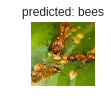

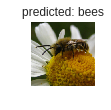

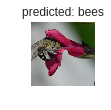

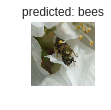

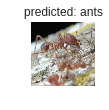

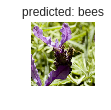

In [16]:
print('Peek into predicted output by Pre-trained  model')
visualize_model(model_resnet)

plt.ioff()
plt.show()

##**Step 3: Try out two different pre-trained networks**


1.   **VGG16 Pre-trained network has been used to make predictions using transfer learning**
       
       The final layer from the classifier has been removed and instead a linear layer that predicts probabilities over two classes has been added (previously VGG16 model had 1000 output classes).
2.   **AlexNet Pre-trained network has been used to make predictions using transfer learning**

      The final layer from the classifier has been removed and instead a linear layer that predicts probabilities over two classes has been added (previously AlexNet model had 1000 output classes).




###**Step 3: 1. Feature Extraction using VGG16 Pre-trained network:**

In [17]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

print('Original:\n', vgg16, '\n')

# Newly created modules will have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)

model_vgg = vgg16.to(device)

print('Modified to have two class output: \n', model_vgg)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Original:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_

In [18]:
# Train phase
print('Training Phase: pre-traind vgg16 model is being trained.\n')
model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Training Phase: pre-traind vgg16 model is being trained.

Epoch 0/29
----------
train Loss: 0.3803 Acc: 0.8566
val Loss: 0.2136 Acc: 0.9346

Epoch 1/29
----------
train Loss: 0.3813 Acc: 0.8443
val Loss: 0.1847 Acc: 0.9346

Epoch 2/29
----------
train Loss: 0.2558 Acc: 0.8852
val Loss: 0.2270 Acc: 0.9150

Epoch 3/29
----------
train Loss: 0.2836 Acc: 0.8607
val Loss: 0.2334 Acc: 0.9216

Epoch 4/29
----------
train Loss: 0.3299 Acc: 0.8607
val Loss: 0.1907 Acc: 0.9281

Epoch 5/29
----------
train Loss: 0.2035 Acc: 0.8811
val Loss: 0.1971 Acc: 0.9216

Epoch 6/29
----------
train Loss: 0.1564 Acc: 0.9344
val Loss: 0.2577 Acc: 0.9216

Epoch 7/29
----------
train Loss: 0.2140 Acc: 0.9057
val Loss: 0.2128 Acc: 0.9346

Epoch 8/29
----------
train Loss: 0.1607 Acc: 0.9426
val Loss: 0.1866 Acc: 0.9412

Epoch 9/29
----------
train Loss: 0.1351 Acc: 0.9344
val Loss: 0.1809 Acc: 0.9346

Epoch 10/29
----------
train Loss: 0.1365 Acc: 0.9385
val Loss: 0.1767 Acc: 0.9412

Epoch 11/29
----------
train

Peek into predicted output by Pre-trained VGG16 model


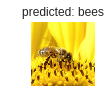

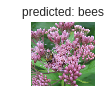

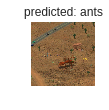

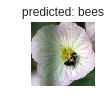

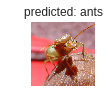

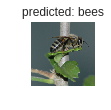

In [19]:
print('Peek into predicted output by Pre-trained VGG16 model')
visualize_model(model_vgg)

plt.ioff()
plt.show()

###**Step 3: 2. Feature Extraction using AlexNet Pre-trained network:**

In [20]:
# Load the pretrained model from pytorch
alexnet = models.alexnet(pretrained=True)

# Freeze training for all layers
for param in alexnet.features.parameters():
    param.require_grad = False

print('Original:\n', alexnet, '\n')

# Newly created modules will have require_grad=True by default
num_features = alexnet.classifier[6].in_features
features = list(alexnet.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
alexnet.classifier = nn.Sequential(*features)

model_alexnet = alexnet.to(device)

print('Modified to have two class output: \n', model_alexnet)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Original:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, 

In [21]:
# Train phase
print('Training Phase: pre-trained alexnet model getting trained.\n')
model_alexnet = train_model(model_alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Training Phase: pre-traind alexnet model is being trained.

Epoch 0/29
----------
train Loss: 0.8708 Acc: 0.6311
val Loss: 0.7082 Acc: 0.5882

Epoch 1/29
----------
train Loss: 0.6666 Acc: 0.5861
val Loss: 0.6374 Acc: 0.6340

Epoch 2/29
----------
train Loss: 0.6035 Acc: 0.6885
val Loss: 0.5709 Acc: 0.6732

Epoch 3/29
----------
train Loss: 0.5354 Acc: 0.7705
val Loss: 0.4617 Acc: 0.7908

Epoch 4/29
----------
train Loss: 0.5042 Acc: 0.7295
val Loss: 0.6217 Acc: 0.6732

Epoch 5/29
----------
train Loss: 0.5905 Acc: 0.6598
val Loss: 0.5750 Acc: 0.7320

Epoch 6/29
----------
train Loss: 0.5094 Acc: 0.7582
val Loss: 0.6778 Acc: 0.6797

Epoch 7/29
----------
train Loss: 0.4468 Acc: 0.7582
val Loss: 0.5585 Acc: 0.7843

Epoch 8/29
----------
train Loss: 0.3865 Acc: 0.8156
val Loss: 0.5112 Acc: 0.8105

Epoch 9/29
----------
train Loss: 0.3079 Acc: 0.8566
val Loss: 0.4912 Acc: 0.8301

Epoch 10/29
----------
train Loss: 0.2738 Acc: 0.8811
val Loss: 0.4714 Acc: 0.8301

Epoch 11/29
----------
tra

Peek into predicted output by Pre-trained ALEXNET model


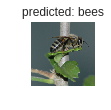

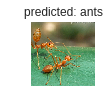

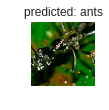

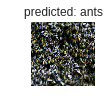

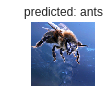

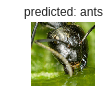

In [22]:
print('Peek into predicted output by Pre-trained ALEXNET model')
visualize_model(model_alexnet)

plt.ioff()
plt.show()

##**Step 4: Custom clicked/input Image classification using VGG model**

In [23]:
!pip install -U -q PyDrive
%matplotlib inline

from __future__ import print_function, division
from google.colab import auth
from googleapiclient.http import MediaIoBaseDownload
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
import requests
from torch.autograd import Variable
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy
from googleapiclient.discovery import build
import json
import io

print('Required imports done.')

Required imports done.


In [24]:
# authenticate user to access google drive.
auth.authenticate_user()

drive_service = build('drive', 'v3')

# Download the image from google drive.
file_id = '1XoO5ZCjise5SZxDyl0-dFB8DUV5EtORZ'

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False

while done is False:
  # _ is a placeholder for a progress object that we ignore.
  _, done = downloader.next_chunk()

downloaded.seek(0)
bytes_read = downloaded.read()
image = Image.open(io.BytesIO(bytes_read))

print('Downloaded file contents are: {}'.format(image))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Device supports CUDA: ', device)

Downloaded file contents are: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3456x4608 at 0x7F49C007A4A8>
cuda:0
Device supports CUDA:  cuda:0


In [32]:
# convert the downloaded custom input image to tensor so that it can be fed to the model.
loader = transforms.Compose([transforms.Resize(256),  transforms.CenterCrop(224), transforms.ToTensor()])

# function to transform input image to have it aligned with VGG model's structure.
def image_loader(image_name):
    image = loader(image_name).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0) 
    return image.to(device)
  
inputs = image_loader(image)
print('data loaded successfully.')

data loaded successfully.


Input Image: 



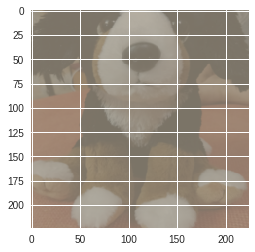

torch.Size([1, 3, 224, 224])


In [33]:
# show input image inline in the notebook.
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.485, 0.456, 0.406])
    std = numpy.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

print('Input Image: \n')  
imshow(inputs.squeeze(0).cpu())
print(inputs.shape)

In [34]:
# Load the pretrained model from pytorch
vgg16 = models.alexnet(pretrained=True)
vgg16 = vgg16.to(device)

print('Pre-trained VGG16 model loaded.')

print('Original:\n', vgg16, '\n')

Pre-trained VGG16 model loaded.
Original:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
  

In [35]:
# predict label for custom input image given.
outputs = vgg16(inputs)

# get the predicted class data.
_, preds = torch.max(outputs.data, 1)
print(preds)

# get list of all 1000 imagenet class names.
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_names = json.load(io.BytesIO(r.content))
labels = [class_names[str(k)][1] for k in range(len(class_names))]

# print the predicted class label.
print('Predicted label: ', labels[preds])

tensor([850], device='cuda:0')
Predicted label:  teddy


**Reasoning:**
Since I have as such used the pre-trained VGG model (that has been trained on imagenet), it will have initial layers that would have learnt the higher-level genralized features of object detection but the outer layers will have features that are fine-tuned to images of imagenet dataset. Thus, the prediction isn't very accurate. For e.g, here the model predicts a soft toy (puppy) given as input as 'teddy' for the above stated reason. If the later layers are fine-tuned, better results can be achieved as shown through task 2, step3. Moreover, the input image may not fall accurately into one of the 1000 classes described in imagenet, thus user-defined or new class labels can be added and the model can be made to learn that with a good amount of data being fed to it (to avoid over-fitting). Finally, we have also resized and random cropped the input image, in which case a significant portion of the image (features) would have been lost. This is another major reason as to why VGG16 performs not so good on the given custom input image.

## Submission

For task 1 add your changes to the cells in this notebook.

For task 2 append the required fields of the the transfer learning tutorial to this notebook and make the required modifications. Ensure that you have clear section headings that show where you undertake which parts of the question.

Save this notebook containing all images and upload your submission as one [A6.ipynb](A6.ipynb) file.